In [2]:
import numpy as np
import matplotlib.pyplot as plt
from qutip import *
from sync_calcs import calculate_steady_state, spin_husimi_qfunc, spin_S_measure
from sync_plots import angle_xaxis

qutip.settings.has_mkl = False  # Fix the OS erros in VSCode


In [2]:
# Plotting constants
n = 50  # angle array size scale

theta = np.linspace(0, np.pi, n)
phi = np.linspace(-np.pi, np.pi, 2 * n).reshape(-1, 1)  # 1D vector -> 2D column vector

# Detuning $\times$ Phase $\times$ $S$

In [3]:
gain_amp=1
loss_amp=0.1

In [4]:
DR = 1
detunings = np.linspace(-DR, DR, n)

In [5]:

S = np.zeros([2*n, n])

for i, D in enumerate(detunings):
    state = calculate_steady_state(gain_amp=gain_amp, loss_amp=loss_amp, signal_strength=loss_amp, detuning=D)
    s = state.full()
    s[0,0], s[1,1] = s[1,1], s[0,0]
    s[0,1], s[1,0] = s[1,0], s[0,1]
    state = Qobj(s)
    Q = spin_husimi_qfunc(state, theta, phi)
    s = spin_S_measure(theta, Q)

    S[:, i] = s

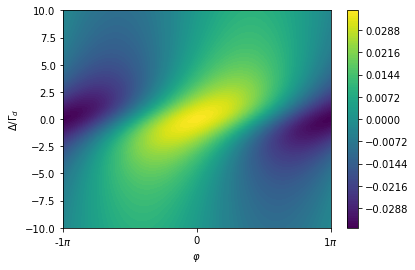

In [6]:
fig, ax = plt.subplots()

DETUNING, PHI = np.meshgrid(detunings / loss_amp, phi)

cquad = ax.contourf(PHI, DETUNING, S, 100)
ax.set_xlabel(r'$\varphi$')
ax.set_ylabel(r'$\Delta/\Gamma_d$')

fig.colorbar(cquad)
angle_xaxis(ax)

# Strength $\times$ Phase $\times$ $S$

In [7]:
gain_amp=1
loss_amp=0.1

In [8]:
ER = 0.1
strengths = np.linspace(0, ER, n)


In [9]:

S = np.zeros([2*n, n])

for i, E in enumerate(strengths):
    state = calculate_steady_state(gain_amp=gain_amp, loss_amp=loss_amp, signal_strength=E, detuning=0)
    s = state.full()
    s[0,0], s[1,1] = s[1,1], s[0,0]
    s[0,1], s[1,0] = s[1,0], s[0,1]
    state = Qobj(s)
    Q = spin_husimi_qfunc(state, theta, phi)
    s = spin_S_measure(theta, Q)

    S[:, i] = s

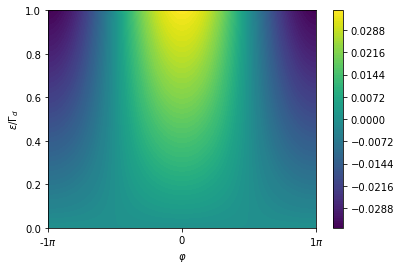

In [10]:
fig, ax = plt.subplots()

STRENGTHS, PHI = np.meshgrid(strengths / loss_amp, phi)

cquad = ax.contourf(PHI, STRENGTHS, S, 100)
ax.set_xlabel(r'$\varphi$')
ax.set_ylabel(r'$\varepsilon/\Gamma_d$')

fig.colorbar(cquad)
angle_xaxis(ax)

# Strength $\times$ Detuning $\times$ $\max(S)$

In [11]:
gain_amp=1
loss_amp=0.1

In [12]:
n = 50

DR = 1
detunings = np.linspace(-DR, DR, 2*n)

ER = 0.1
strengths = np.linspace(0, ER, n)

In [13]:
Smax = np.zeros([2 * n, n])

from utils import profile

# @profile
def calc():
    for i, D in enumerate(detunings):
        for j, E in enumerate(strengths):
            state = calculate_steady_state(gain_amp=gain_amp, loss_amp=loss_amp, signal_strength=E, detuning=D)
            s = state.full()
            s[0, 0], s[1, 1] = s[1, 1], s[0, 0]
            s[0, 1], s[1, 0] = s[1, 0], s[0, 1]
            Q = spin_husimi_qfunc(state, theta, phi)
            s = spin_S_measure(theta, Q)

            Smax[i, j] = np.max(s)

calc()


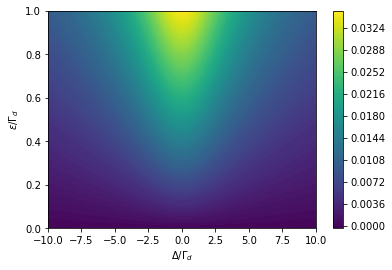

In [14]:
fig, ax = plt.subplots()

DETUNINGS, STRENGTHS  = np.meshgrid(detunings / loss_amp, strengths / loss_amp)

cquad = ax.contourf(DETUNINGS, STRENGTHS, Smax.T, 100)
ax.set_xlabel(r'$\Delta/\Gamma_d$')
ax.set_ylabel(r'$\varepsilon/\Gamma_d$')

fig.colorbar(cquad)

# Gates

In [3]:
from qutip.qip.circuit import QubitCircuit, Gate, gate_sequence_product

## IBM Q Gates

In [4]:
def U3(args):
    theta, phi, lambda_ = args
    matrix = [
        [np.cos(theta / 2), -np.exp(1j * lambda_) * np.sin(theta / 2)],
        [np.exp(1j * phi) * np.sin(theta / 2), np.exp(1j * lambda_ + 1j * phi) * np.cos(theta / 2)],
    ]
    return Qobj(matrix, dims=[[2], [2]])


In [5]:
def CU3(args):
    mat = np.zeros((4, 4), dtype=complex)
    mat[0, 0] = mat[1, 1] = 1.0
    mat[2:4, 2:4] = U3(args)

    return Qobj(mat, dims=[[2, 2], [2, 2]])

CU3([1, 1, 1])


Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[ 1.        +0.j          0.        +0.j          0.        +0.j
   0.        +0.j        ]
 [ 0.        +0.j          1.        +0.j          0.        +0.j
   0.        +0.j        ]
 [ 0.        +0.j          0.        +0.j          0.87758256+0.j
  -0.25903472-0.40342268j]
 [ 0.        +0.j          0.        +0.j          0.25903472+0.40342268j
  -0.36520321+0.79798357j]]

## Other Gates

In [6]:
def MEASURE(state):
    return basis(2, state) * basis(2, state).dag()

## Relaxation Circuit

In [21]:
Gamma = 1
dt = 0.5
theta = 2*np.arcsin(np.sqrt(Gamma * dt))

In [22]:
qc = QubitCircuit(2, user_gates={"U3": U3, "CU3": CU3, "MEASURE": MEASURE})

qc.add_gate("CU3", arg_value=[theta, 0, 0])
qc.add_gate("CNOT", targets=[0], controls=[1])
qc.add_gate("MEASURE", arg_value=0, targets=[1])

p = qc.propagators()

D = gate_sequence_product(p)

In [23]:
D

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[ 1.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.70710678 -0.70710678]
 [ 0.          0.          0.          0.        ]]

In [29]:
target_qubit = basis(2, 1)
anch_qubit = basis(2, 0)

state = tensor(target_qubit, anch_qubit)

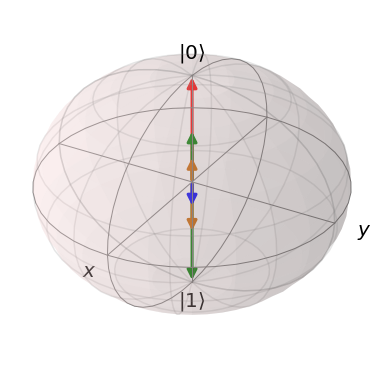

In [31]:
b = Bloch()

b.add_states([state.ptrace(0), (D * state).ptrace(0), (D ** 2 * state).ptrace(0)])
b.add_states([state.ptrace(1), (D * state).ptrace(1), (D ** 2 * state).ptrace(1)])

b.show()
